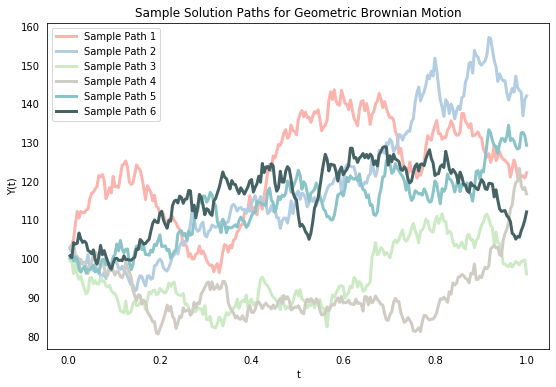

In [20]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
pal = ["#FBB4AE","#B3CDE3", "#CCEBC5","#CFCCC4","#8bc4c8","#456264"]

# SDE model parameters
mu, sigma, X0, r = 0.1, 0.25, 100, 0.05

# Simulation parameters
T, N, M = 1, 255, 100
dt = T / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

# Initiate plot object
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.ylabel('Y(t)'); plt.xlabel('t')

# Create and plot sample paths
for i in range(len(pal)):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Compute exact solution
    Y = X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * B)
    
    # Add line to plot
    plt.plot(t, Y, label = "Sample Path " + str(i+1), color=pal[i])

# Add legend
plt.legend(loc = 2);

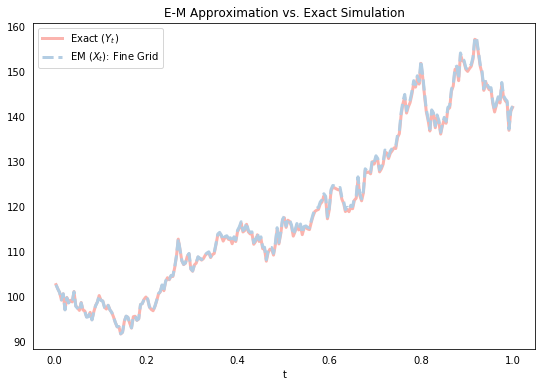

In [23]:
# Create Brownian Motion
np.random.seed(1)
dB = np.sqrt(dt) * np.random.randn(N)
B  = np.cumsum(dB)

# Exact Solution
Y = X0 * np.exp((mu - 0.5*sigma**2)*t + (sigma * B))

# EM Approximation - small dt
X_em_small, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j]
    X_em_small.append(X)

# EM Approximation - big dt
X_em_big, X, R = [], X0, 2
coarse_grid = np.arange(dt,1+dt,R*dt)
for j in range(int(N/R)):
    X += mu*X* (R*dt) + sigma*X*sum(dB[R*(j-1):R*j])
    X_em_big.append(X)    
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)", color=pal[0])
plt.plot(t, X_em_small, label="EM ($X_t$): Fine Grid", color=pal[1], ls='--')
plt.title('E-M Approximation vs. Exact Simulation'); plt.xlabel('t'); plt.legend(loc = 2);

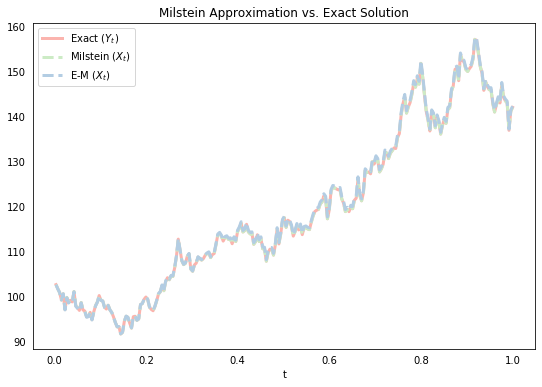

In [24]:
# Milstein Approximation
Xmil, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j] + 0.5*sigma**2 * X * (dB[j] ** 2 - dt)
    Xmil.append(X)
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)",color=pal[0])
plt.plot(t, Xmil, label="Milstein ($X_t$)",color=pal[2],ls='--')
plt.plot(t, X_em_small, label="E-M ($X_t$)",color=pal[1],ls='--')
plt.title('Milstein Approximation vs. Exact Solution')
plt.xlabel('t'); plt.legend(loc=2);

In [25]:
# Initiate dt grid and lists to store errors
str_err_em, str_err_mil, weak_err_em, weak_err_mil = [], [], [], []
dt_grid = np.array([0.05, 0.01, 0.1, 0.5, 1, 2, 4])
M = 100

# Loop over values of dt
for Dt in dt_grid:
    
    # Setup discretized grid 
    N = int(T/Dt)
    t = np.linspace(0, T, N+1,endpoint=True)
    n = len(t)
    
    # Initiate vectors to store errors and time series
    err_em, err_mil = np.zeros(n), np.zeros(n)
    Y_sum, Xem_sum, Xmil_sum = np.zeros(n), np.zeros(n), np.zeros(n)
    
    # Generate many sample paths
    for i in range(M):
        
        # Create Brownian Motion
        np.random.seed(i)
        dB = np.sqrt(Dt) * np.random.randn(n)
        B  = np.cumsum(dB)
        
        # Exact solution
        Y = X0 * np.exp((mu - 0.5*sigma**2)*t + sigma * B)
        
        # Simulate stochastic processes
        Xemt, Xmilt, Xem, Xmil = X0, X0, [], []
        for j in range(n):

            # Euler-Maruyama
            Xemt += mu*Xemt* Dt + sigma * Xemt * dB[j]
            Xem.append(Xemt)
            
            # Milstein
            Xmilt += mu*Xmilt*Dt + sigma*Xmilt*dB[j] + 0.5*sigma**2*Xmilt*(dB[j]**2 - Dt)
            Xmil.append(Xmilt)
            
        # Compute strong errors and add to those across from other sample paths
        err_em  += abs(Y - Xem)
        err_mil += abs(Y - Xmil)

        # Add Y and X values to previous sample paths
        Y_sum += Y
        Xem_sum += Xem
        Xmil_sum += Xmil
        
    # Compute mean of absolute errors and find last (strong error)
    em_er = err_em / M
    m_er = err_mil / M
    str_err_em.append(em_er[len(em_er)-1])
    str_err_mil.append(m_er[len(em_er)-1])
    
    # Compute error of means and find maximum (weak error)
    em_w = abs(Y_sum - Xem_sum)/M
    m_w = abs(Y_sum - Xmil_sum)/M
    weak_err_em.append(abs(em_w[len(em_w)-1]))
    weak_err_mil.append(abs(m_w[len(m_w)-1]))

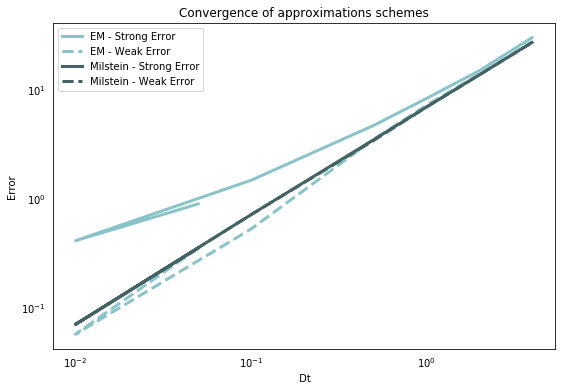

In [26]:
# Plot
plt.loglog(dt_grid, str_err_em, label="EM - Strong Error",color=pal[4])
plt.loglog(dt_grid, weak_err_em, label="EM - Weak Error",color=pal[4],ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Strong Error",color=pal[5])
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Weak Error",color=pal[5],ls='--')
plt.title('Convergence of approximations schemes')
plt.xlabel(' Dt'); plt.ylabel('Error'); plt.legend(loc=2);

In [27]:
# Import packages and setup design matrix
import statsmodels.api as sm
X = sm.add_constant(np.log(dt_grid))

# Run OLS on above simulations to estimate gamma values
results = sm.OLS(np.log(weak_err_em),X).fit()
print("Weak E-M Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_mil),X).fit()
print("Weak Milstein Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_em),X).fit()
print("\nStrong E-M Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_mil),X).fit()
print("Strong Milstein Convergence: "+ str(results.params[1]))

Weak E-M Convergence:        1.0355633965312288
Weak Milstein Convergence:   0.9942690074079054

Strong E-M Convergence:      0.7219875148572706
Strong Milstein Convergence: 0.9945825959668924
